# **SAR to Optical Image Translation using cGANs**

This notebook demonstrates the capability of [Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004) to map SAR data to Optical data. 






---

## **Overview**
<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/overview.png' />
</figure>

---

## **cGANs training**
---
<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/cgans_training.png'/>
</figure>

---


## **Methodology**
---
<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/pipeline.png' />
</figure>

---


# **Dataset**



## [**LEM municipality:**](http://www.lvc.ele.puc-rio.br/LEM_benchmark/dataset.html)



*   Location: West of Bahia state, in Northeast of Brazil, in the Cerrado Biome (Brazilian Savannah)
*   Area: 3,940.537 km²
* Acquicition Dates: From June 4, 2017 to June 29, 2018
* Main classes: Soybean, Maize, Cotton and Rice.
<figure>
<center>
<img src= 'http://www.lvc.ele.puc-rio.br/LEM_benchmark/images/LEM_location.png' />
</figure>




---
<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/S1vsS2.png' />
</figure> 

---

The images archired on **June 19, 2018**


In [ ]:
from google.colab import drive
# # mount your Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
# os.chdir("/content/drive/My Drive/Colab Notebooks/Tutorial/")
os.chdir("/content/drive/My Drive/Colab Notebooks/")
# os.chdir("/content/drive/u/")

In [ ]:
# take araound two minutes clone the project
# !git clone https://gitlab.com/josebermudez/data.git

fatal: destination path 'data' already exists and is not an empty directory.


In [ ]:
# !unzip data/data.zip

Archive:  data/data.zip
replace data/20180619_S1A_10m/clip_20180619T083553_Sigma0_VH_cut_db.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Import libraries

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import gdal
import skimage
import tensorflow as tf
import keras.backend as K

from skimage.transform import resize
from keras import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Lambda, Dropout, BatchNormalization, Add, Concatenate
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import  Activation, Reshape, Dense, Flatten, ZeroPadding2D
from keras.models import save_model, load_model
from keras.initializers import RandomNormal

Using TensorFlow backend.


## Load the images

In [ ]:
def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    return data

def load_sentinel_data(path):
    img_paths = sorted(glob.glob(path + '*.tif'))
    image = [np.expand_dims(read_tiff(img).astype('float32'), -1) for img in img_paths]
    image = np.concatenate(image, axis=-1)
    print("Image shape: ", image.shape, " Min value: ", image.min(), " Max value: ", image.max())
    return image

In [ ]:
S2_img = load_sentinel_data('data/20180619_S2A_10m/')
S1_img = load_sentinel_data('data/20180619_S1A_10m/')

Image shape:  (8478, 6827, 4)  Min value:  0.0  Max value:  8243.0
Image shape:  (8478, 6827, 2)  Min value:  -37.981373  Max value:  21.201277


## Split image into training, validation and testing tiles

* Create an image of indexes to reduce the computational requirements.
* Split the index image into a grid of tiles
* Define the validation and testing tiles,
* Create a mask for training, validation and testing.
* Training = 0, validation = 1, testing = 2.

In [ ]:
def create_idx_image(rows, cols):
    im_idx = np.arange(rows * cols).reshape(rows, cols)
    return im_idx

def extract_patches(im_idx, patch_size, overlap):
    '''overlap range: 0 - 1 '''
    row_steps, cols_steps = int((1-overlap) * patch_size[0]), int((1-overlap) * patch_size[1])
    patches = skimage.util.view_as_windows(im_idx, patch_size, step=(row_steps, cols_steps))
    return patches

def define_trn_val_tst_mask(tiles_grid_idx, grid_size=(10,10), val_tiles=None, tst_tiles=None, plot=True):
    num_tiles_rows = grid_size[0]
    num_tiles_cols = grid_size[1]

    tiles_idx = np.arange(len(tiles_grid_idx))
    if val_tiles and tst_tiles:
        val_tiles_idx = val_tiles
        tst_tiles_idx = tst_tiles
        trn_tiles_idx = set(tiles_idx) - set(val_tiles_idx) - set(tst_tiles_idx)
    else:        
        tiles_idx = np.random.permutation(tiles_idx)
        trn_tiles_idx = tiles_idx[:int(0.9*len(tiles_idx))]
        val_tiles_idx = tiles_idx[int(0.9*len(tiles_idx)):int(0.95*len(tiles_idx))]
        tst_tiles_idx = tiles_idx[int(0.95*len(tiles_idx)):]

    print(val_tiles_idx, tst_tiles_idx)

    tiles_numbers = np.zeros_like(tiles_grid_idx, dtype='uint8')
    for i in range(len(tiles_grid_idx)):
        tiles_numbers[i] = i

    mask = np.zeros_like(tiles_grid_idx, dtype='uint8')
    for idx in val_tiles_idx:
        mask[tiles_numbers==idx] = 1
    for idx in tst_tiles_idx:
        mask[tiles_numbers==idx] = 2

    mask = mask_tiles(mask.reshape(num_tiles_rows, num_tiles_cols, rows//num_tiles_rows, cols//num_tiles_cols))
    if plot:
        plt.figure(figsize=(5,5))
        plt.imshow(mask, cmap='PuBuGn')
        plt.axis('off')
        plt.show()
        plt.close()
    return mask

def mask_tiles(patches):
    num_blocks_r, num_blocks_c, rows_block, cols_block = patches.shape
    img = np.zeros((num_blocks_r*rows_block, num_blocks_c*cols_block), dtype=patches.dtype)
    for i in range(num_blocks_r):
        for j in range(num_blocks_c):
            img[rows_block*i:(rows_block*i+rows_block), cols_block*j:(cols_block*j+cols_block)] = patches[i,j]
    return img

In [ ]:
# define the image of indexes
rows, cols = S2_img.shape[:2]
im_idx = create_idx_image(rows, cols)

# Compute grids of tiles
grid_size = (3, 3)
tiles_grid_idx = extract_patches(im_idx, patch_size=(rows//grid_size[0], cols//grid_size[1]), overlap=0).reshape(-1, rows//grid_size[0], cols//grid_size[0])

In [ ]:
tiles_grid_idx[2].shape

(2826, 2275)

[0, 2, 4] [6, 7, 8]


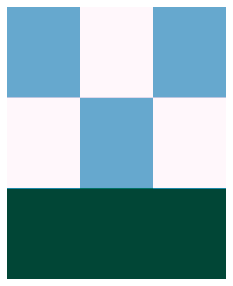

In [ ]:
# Computing and plotting trn, val and tst mask.
# val_tiles=[21, 47, 82]
# tst_tiles=[13, 54, 87]
val_tiles=[0, 2, 4]
tst_tiles=[6, 7, 8]
mask_trn_val_tst = define_trn_val_tst_mask(tiles_grid_idx, grid_size, val_tiles, tst_tiles)

## Extract patches from the training and validation tiles

* Patches are extracted over the index image and the defined mask using ovelap of 50%.
* The mask's patches are used to identify which patches extracted from the index image correspond to training, validation and testing.

In [ ]:
overlap=0
patches_idx = extract_patches(im_idx, patch_size=(256, 256), overlap=overlap).reshape(-1, 256, 256)
patches_mask = extract_patches(mask_trn_val_tst, patch_size=(256, 256), overlap=overlap).reshape(-1, 256, 256)

In [ ]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==0))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==256**2))
# idx_tst = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*256**2))

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]

# print
print('Number of training and validation patches:  ', len(idx_trn), len(idx_val))

Number of training and validation patches:   766 10


## Preprocessing Images

* Convert to intensity image from decibels. ( Sentinel 1 ).
* Filter outliers (Sentinel 1 and 2). For Sentinel 2 tst tiles are excluded of the preporcessing stage.
* Normalize images to [-1 1] range per band.

In [ ]:
def db2intensities(img):
    img = 10**(img/10.0)
    return img

def filter_outliers(img, bins=1000000, bth=0.001, uth=0.999, mask=[0]):
    img[np.isnan(img)]=0 # Filter NaN values.
    if len(mask)==1:
        mask = np.zeros((img.shape[:2]), dtype='int64')
    for band in range(img.shape[-1]):
        hist = np.histogram(img[:mask.shape[0], :mask.shape[1]][mask!=2, band].ravel(),bins=bins) # select not testing pixels
        cum_hist = np.cumsum(hist[0])/hist[0].sum()
        max_value = np.ceil(100*hist[1][len(cum_hist[cum_hist<uth])])/100
        min_value = np.ceil(100*hist[1][len(cum_hist[cum_hist<bth])])/100
        img[:,:, band][img[:,:, band]>max_value] = max_value
        img[:,:, band][img[:,:, band]<min_value] = min_value
    return img

def normalize(img):
    '''image shape: [row, cols, channels]'''
    img = 2*(img -img.min(axis=(0,1), keepdims=True))/(img.max(axis=(0,1), keepdims=True) - img.min(axis=(0,1), keepdims=True)) - 1
    return img

In [ ]:
# to intensity
S1_img = db2intensities(S1_img)
S1_img.min(), S1_img.max()

(0.00015917058, 131.86444)

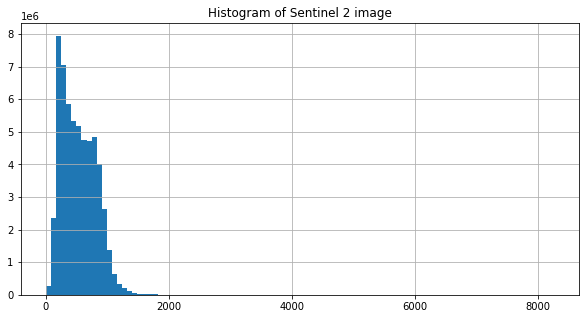

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Histogram of Sentinel 2 image")
plt.hist(S2_img[:,:,0].ravel(), bins=100)
plt.grid()
plt.show()
plt.close()

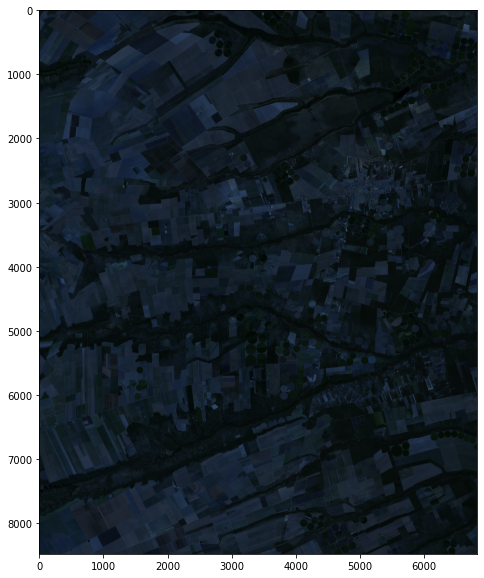

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(S2_img[:,:,:3]/S2_img[:,:,:3].max())
plt.show()
plt.close()

In [ ]:
# Preprocessing images, delecting outliers
S1_img = filter_outliers(S1_img.copy())
S2_img = filter_outliers(S2_img.copy(), bins=int(2**16/2), mask=mask_trn_val_tst)

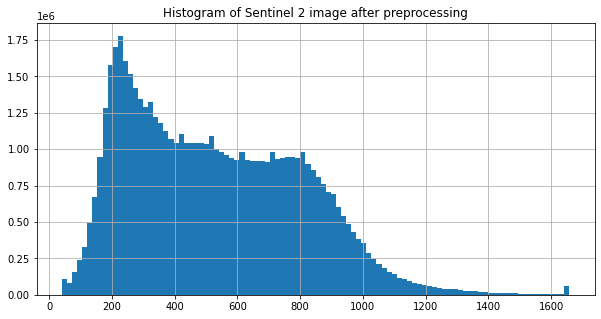

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Histogram of Sentinel 2 image after preprocessing")
plt.hist(S2_img[:,:,0].ravel(), bins=100)
plt.grid()
plt.show()
plt.close()

In [ ]:
# Nomalizing images between [-1 1]
S1_img = normalize(S1_img)
S2_img = normalize(S2_img)
S1_img.min(), S1_img.max(), S2_img.min(), S2_img.max()

(-1.0, 1.0, -1.0, 1.0)

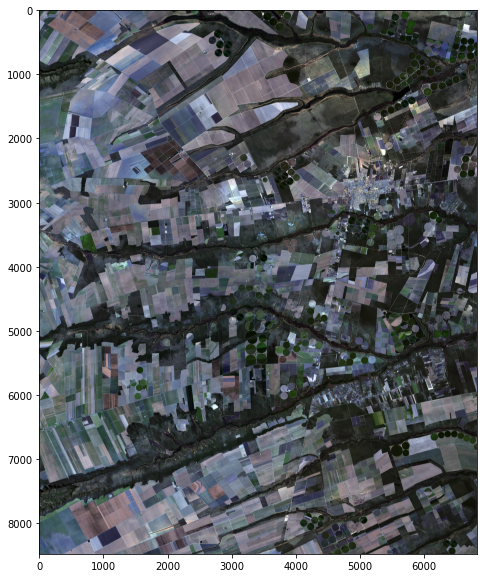

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow((S2_img[:,:,[0,1,2]] + 1)/2)
plt.show()
plt.close()

# **cGANs Training**

In [ ]:
# Architecure Parameters
c_dim_sar = S1_img.shape[-1]
c_dim_opt = S2_img.shape[-1]
n_rows = 256
n_cols = 256

## Data augmentation

1. Resize the paches to bigger height and width.

2. Randomly crop to the target size.

3. Randomly flip the image horizontally.

In [ ]:
# processing_images
def randomResizeCrop(img_s1, img_s2, load_size=286, fine_size=256, flip=True):

    img_s1 = resize(img_s1, [load_size, load_size], 0)
    img_s2 = resize(img_s2, [load_size, load_size], 0)

    h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    img_s1 = img_s1[h1:h1+fine_size, w1:w1+fine_size]
    img_s2 = img_s2[h1:h1+fine_size, w1:w1+fine_size]

    if flip and np.random.random() > 0.5:
        img_s1 = np.fliplr(img_s1)
        img_s2 = np.fliplr(img_s2)

    return img_s1, img_s2

## **Building the Generator**

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/generator_architecture.png' />
</figure>

Proposed on: 
[Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)

Adopted on [Cycle Gans](https://junyanz.github.io/CycleGAN/) based architectures.

Modifications:
* Others normalizations layers: *Instant Normalization*, *Layer Normalization*, etc.
* Multi scale information:
J. N. Turnes, J. D. Bermudez, D L. Torres, P. J. Soto, R. Q. Feitosa,and P. N. Happ,Member “Atrous cGAN for SAR to Optical Image Translation” *IEEE  Geoscience  and  Remote  Sensing Letters*, 




In [ ]:
# define an encoder block
def encoder_block(input_data, n_filters, k_size=3, strides=2, activation='relu', padding='same', batchnorm=True, name='None'):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    x = Conv2D(n_filters, k_size, strides=strides, padding=padding, kernel_initializer=init, name=name+'_conv2D')(input_data)
    if batchnorm:
        x = BatchNormalization(momentum=0.8, name=name+'_bn')(x, training=True)
    if activation is 'LReLU':
        x = LeakyReLU(alpha=0.2, name=name+'_act_LReLU')(x)        
    else:
        x = Activation('relu', name=name+'_act_relu')(x)
    return x

# define a decoder block
def decoder_block(input_data, n_filters, k_size=3, strides=2, padding='same', name='None'):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    x = Conv2DTranspose(n_filters, k_size, strides=strides, padding=padding, kernel_initializer=init, name=name+'_deconv2D')(input_data)
    x = BatchNormalization(momentum=0.8, name=name+'_bn')(x, training=True)
    x = Activation('relu', name=name+'_act_relu')(x)
    return x

def residual_block(input_x, n_kernels, name='name'):
    x = encoder_block(input_x, n_kernels, strides=1, name=name+'rba')
    x = Dropout(0.5, name=name+'drop')(x, training=True)
    x = encoder_block(x, n_kernels,  strides=1, activation='linear', name=name+'rbb')
    x = Add(name=name+'concatenate')([x, input_x])
    return x

In [ ]:
def build_generator2D(model_shape, filters=64, last_act='tanh', n_residuals=9, summary=False, model_file=None, name='gan_g_'):

    init = RandomNormal(stddev=0.02)
    n_rows = model_shape[0]
    n_cols = model_shape[1]
    in_c_dims = model_shape[2]
    out_c_dims = model_shape[3]

    input_shape = (n_rows, n_cols, in_c_dims)
    input_layer = Input(shape=input_shape, name=name+'_input')
    
    x = input_layer
    x = encoder_block(x, 1*filters, k_size=7, strides=1, batchnorm=False, name=name+'_e1')
    x = encoder_block(x, 2*filters, name=name+'e2') # rows/2, cols/2
    x = encoder_block(x, 4*filters, name=name+'e3') # rows/4, cols/4

    for i in range(n_residuals):
        x = residual_block(x, n_kernels=4*filters, name=name+str(i+1)+'_')  # rows/4, cols/4

    x = decoder_block(x, 2*filters, name=name+'d1') # rows/2, cols/2            
    x = decoder_block(x, 1*filters, name=name+'d2') # rows, cols
    x = Conv2D(out_c_dims, 7, padding='same',  kernel_initializer=init, name=name+'d_out')(x)   # rows, cols

    output = Activation(last_act, name=name+last_act)(x)

    model = Model(inputs=[input_layer], outputs=[output], name='Generator'+name[-3:])
    if (summary):
        model.summary()
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Generatorgen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_input (InputLayer)          (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
gen_e1_conv2D (Conv2D)          (None, 256, 256, 64) 6336        gen_input[0][0]                  
__________________________________________________________________________________________________
gen_e1_act_relu (Activation)    (None, 256, 256, 64) 0           gen_e1_conv2D[0][0]              
__________________________________________________________________________________________________
gene2_conv2D (Conv2D)           (None, 128, 128, 128 73856       gen_e1_act_relu[0][0]            
______

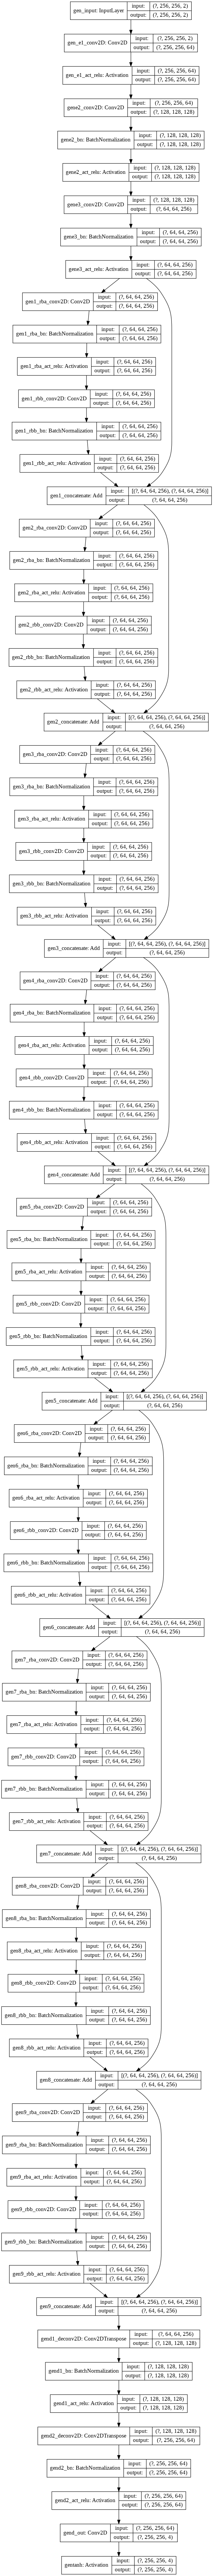

In [ ]:
# Setting the model shape
gen_shape = (n_rows, n_cols, c_dim_sar, c_dim_opt)
generator = build_generator2D(gen_shape, filters=64, name='gen', summary=True)
tf.keras.utils.plot_model(generator, show_shapes=True)


## **Building the Discriminator**

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/Discriminator_architecture.png' />
</figure>

* It inputs the [SAR, OPT] pair and outputs a 30x30 grid of scores.
* The receptive field is 70x70: The output neurons evaluates 70x70 portion of the input image (such an architecture is called a PatchGAN).

* It is composed of 4 encoder blocks.
* The enconder blocks are made of 4x4 Conv -> BN -> LReLU.



In [ ]:
########################  NETWORK ARCHITECTURES  ###############################
def build_discriminator2D(input_shape, filters=64, name='d', summary=False):
    """
    Create a Discriminator Model using hyperparameters values defined as follows
    """
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    input_img  = Input(shape=input_shape, name=name+'_input')
    d = input_img
    d = encoder_block(d, 1*filters, k_size=4, activation='LReLU', batchnorm=False, name=name+'_1')
    d = encoder_block(d, 2*filters, k_size=4, activation='LReLU', name=name+'_2')
    d = encoder_block(d, 4*filters, k_size=4, activation='LReLU', name=name+'_3')

    d = ZeroPadding2D()(d)
    d = encoder_block(d, 8*filters, k_size=4, activation='LReLU', strides=1, padding='valid', name=name+'_4')
    d = ZeroPadding2D()(d)
    logits = Conv2D(1, (4,4), padding='valid', kernel_initializer=init, name=name+'_conv2D_5')(d)
    out = Activation('sigmoid', name=name+'_act_sigmoid')(logits)

    model = Model(inputs=[input_img], outputs=[out, logits], name=name)
    if (summary):
        model.summary()
    return model

In [ ]:
dis_shape = (n_rows, n_cols, c_dim_sar + c_dim_opt)
discriminator = build_discriminator2D(dis_shape, filters=64, name='dis', summary=True)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Model: "dis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dis_input (InputLayer)       (None, 256, 256, 6)       0         
_________________________________________________________________
dis_1_conv2D (Conv2D)        (None, 128, 128, 64)      6208      
_________________________________________________________________
dis_1_act_LReLU (LeakyReLU)  (None, 128, 128, 64)      0         
_________________________________________________________________
dis_2_conv2D (Conv2D)        (None, 64, 64, 128)       131200    
_________________________________________________________________
dis_2_bn (BatchNormalization (None, 64, 64, 128)       512       
_________________________________________________________________
dis_2_act_LReLU (LeakyReLU)  (None, 64, 64, 128)       0         
_________________________________________________________________
dis_3_conv2D (Conv2D)        (None, 32, 32, 256)       524544  

## **Loss functions**


In [ ]:
def cross_entropy_loss(labels, logits):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return loss

def lsgan_loss(labels, logits):
        loss = tf.reduce_mean(tf.squared_difference(logits, labels))
        return loss 
    
def l1_loss(a, b):
    loss = tf.reduce_mean(tf.abs(a - b))
    return loss

## **Building the Computational Graph**


In [ ]:
K.clear_session() # cleaning previous sessions

batch_size = 1
LAMBDA = 100

# BUILDING NETWORKS GRAPHS
Generator = build_generator2D(gen_shape, filters=64, name='gen', summary=False)
Discriminator = build_discriminator2D(dis_shape, filters=64, name='dis', summary=False)

# GRAPH INPUT DATA
REAL_SAR = tf.placeholder(tf.float32,
                        [batch_size, n_rows, n_cols, c_dim_sar],
                        name='real_sar')

REAL_OPT = tf.placeholder(tf.float32,
                        [batch_size, n_rows, n_cols, c_dim_opt],
                        name='real_opt')

FAKE_OPT = Generator(REAL_SAR)

REAL_PAIR = tf.concat([REAL_SAR, REAL_OPT], axis=-1)
FAKE_PAIR = tf.concat([REAL_SAR, FAKE_OPT], axis=-1)

# Discriminator
D_real, D_real_logits = Discriminator(REAL_PAIR)
D_fake, D_fake_logits = Discriminator(FAKE_PAIR)

# Discriminator loss,
d_loss_real = cross_entropy_loss(tf.ones_like(D_real), D_real_logits)
d_loss_fake = cross_entropy_loss(tf.zeros_like(D_real), D_fake_logits)
d_loss = (d_loss_real + d_loss_fake) / 2.0

# Reconstruction loss
reco_loss = LAMBDA * l1_loss(REAL_OPT, FAKE_OPT)

# Generator loss,
g_loss_ = cross_entropy_loss(tf.ones_like(D_fake), D_fake_logits)
g_loss =  g_loss_ + reco_loss

KeyboardInterrupt: ignored

### Defining Optimizers for the Networks

In [ ]:
# Collecting variables for training
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'dis' in var.name] # Discriminator variables
g_vars = [var for var in t_vars if 'gen' in var.name] # Generator variables

# Optimizer parameters
lr_d = 0.0002
lr_g = 0.0002
beta1 = 0.5

# Assings variables and corresponding lossses to be minimized
d_optim = tf.train.AdamOptimizer(lr_d, beta1=beta1).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(lr_g, beta1=beta1).minimize(g_loss, var_list=g_vars)

# Build the graph
sess = tf.Session()

# Initialize the all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

### Setting Hyperparameters 

In [ ]:
epochs = 100
patience = 15 # for early stoppig
num_of_trn_batches = len(patches_idx_trn) // batch_size
num_of_val_batches = len(patches_idx_val) // batch_size

g_steps = 1

saving_path = './'

name = 'sar2opt'

restore = False

In [ ]:
def get_next_batch_generator(patches_idx, s1data, s2data, batch_size=1, shuffle=True, flip=True, train=True):
    num_of_batches = len(patches_idx) // batch_size
    s1data = s1data.reshape(-1, s1data.shape[-1])
    s2data = s2data.reshape(-1, s2data.shape[-1])
    if shuffle:
        np.random.shuffle(patches_idx)
    while True:
        for idx in range(num_of_batches):
            patches_idx_batch = patches_idx[idx*batch_size:(idx+1)*batch_size]
            batch_s1_patches, batch_s2_patches = [], []
            for batch_idx in patches_idx_batch:
                batch_s1, batch_s2 = s1data[batch_idx], s2data[batch_idx]
                if train:
                    # data augmentation
                    batch_s1, batch_s2 = randomResizeCrop(batch_s1, batch_s2, flip=flip)
                batch_s1_patches.append(batch_s1)
                batch_s2_patches.append(batch_s2)

            yield np.array(batch_s1_patches), np.array(batch_s2_patches)
        
        if shuffle:
            np.random.shuffle(patches_idx)
        idx = 0
    
def plot_images(sar, real_opt, fake_opt, figsize=(10, 5)):
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(131)
    plt.title('SAR Image')
    ax1.imshow((np.squeeze(sar)[:,:,0]+1)/2., cmap='gray')
    ax1.axis('off')

    ax2 = fig.add_subplot(132)
    plt.title('Target')
    ax2.imshow((np.squeeze(real_opt)[:,:,:3]+1)/2.)
    ax2.axis('off')

    ax2 = fig.add_subplot(133)
    plt.title('Predicted')
    ax2.imshow((np.squeeze(fake_opt)[:,:,:3]+1)/2.)
    ax2.axis('off')

    plt.show()
    # fig.savefig(save_img_path+name+'_img_pt_br_2_elastic_'+str(epoch))
    plt.close() 

In [ ]:
get_next_trn_batch = get_next_batch_generator(patches_idx_trn, S1_img, S2_img, flip=True)
get_next_val_batch = get_next_batch_generator(patches_idx_val, S1_img, S2_img, train=False)

### Training the model

In [ ]:
with tf.Session() as sess:
    sess.run(init_op)

    if restore:
        # Restore variables from disk.
        saver.restore(sess, saving_path+name +".ckpt")
        print("Model restored.")    
    
    
    best_val_loss = np.inf
    for epoch in range(epochs):
        loss_D, loss_G, loss_l1 = [], [], []
    
        start_time = time.time()
        for idx in range(0, num_of_trn_batches):
            
            # selecting a batch of images
            batch_sar, batch_opt = next(get_next_trn_batch)

            feed_dict={REAL_SAR: batch_sar, REAL_OPT: batch_opt}
            
            # Update D networks
            sess.run([d_optim], feed_dict=feed_dict)

            # Update G network
            for g_ in range(g_steps):
                sess.run([g_optim], feed_dict=feed_dict)

            with sess.as_default():
                errD = d_loss.eval(feed_dict)
                errG = g_loss_.eval(feed_dict)
                errl1 = reco_loss.eval(feed_dict)
                loss_D.append(errD)
                loss_G.append(errG)
                loss_l1.append(errl1)                

            if idx % (num_of_trn_batches//1) == 0:
                print('Random training samples')
                pred = Generator.predict(batch_sar)
                plot_images(batch_sar, batch_opt, pred)
        
        # Evaluating model on validation,
        val_loss = []
        for _ in range(0, num_of_val_batches):
            batch_sar, batch_opt = next(get_next_val_batch)
            feed_dict={REAL_SAR: batch_sar, REAL_OPT: batch_opt}
            val_loss.append(reco_loss.eval(feed_dict))

        if best_val_loss > np.mean(val_loss):
            patience = 15
            best_val_loss = np.mean(val_loss)
            print('Saving best model and checkpoints')
            save_model(Generator, saving_path+name+'_gen_net.h5')
            save_model(Discriminator, saving_path+name+'_dis_net.h5')
            # Save the variables to disk.
            saver.save(sess, saving_path+name +".ckpt")
            print('Ok')
        else:
            patience -= 1
        if patience < 0:
            break

        elapsed_time = time.time() - start_time
        
        print('Epoch: ', epoch, 'Elapsed time:', elapsed_time,  'Val_loss: ', np.mean(val_loss))
        print('Dx_loss :', np.mean(loss_D), 'G_loss :', np.mean(loss_G), 'l1_loss :', np.mean(loss_l1))
        
        print('Random validations samples')
        pred = Generator.predict(batch_sar)

        plot_images(batch_sar, batch_opt, pred)

In [ ]:
## Cleaning the session to load best model
K.clear_session()

## Evaluate the model on the test regions

In [ ]:
class sar2opt_model(object):    
    def __init__(self, model_weights, input_dim=c_dim_sar):
        self.model_weights=model_weights
        self.input_dim=input_dim
        self.gen_net = self.load_gen_model()
    
    def load_gen_model(self):
        gen_net = load_model(self.model_weights)
        gen_net.layers.pop(0)
        new_input = Input(shape=(None, None, self.input_dim), name='input')
        new_output = gen_net(new_input)
        net = Model(inputs=[new_input], outputs=[new_output], name='sar2optical')
        return net

    def predict(self, image):
        rows, cols = image.shape[:2]
        new_img = self.toNewImgSize(image)
        pred = self.gen_net.predict(new_img)
        pred = np.squeeze(pred)[:rows, :cols]
        return pred

    def toNewImgSize(self, image):
        rows, cols = image.shape[:2]
        new_rows = rows + 4 - rows % 4
        new_cols = cols + 4 - cols % 4
        NewImg = image.max() * np.ones((new_rows, new_cols, c_dim_sar))
        NewImg[:rows, :cols] = image.copy()
        return np.expand_dims(NewImg,0)

In [ ]:
gen_model = sar2opt_model('sar2opt_gen_net.h5')

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


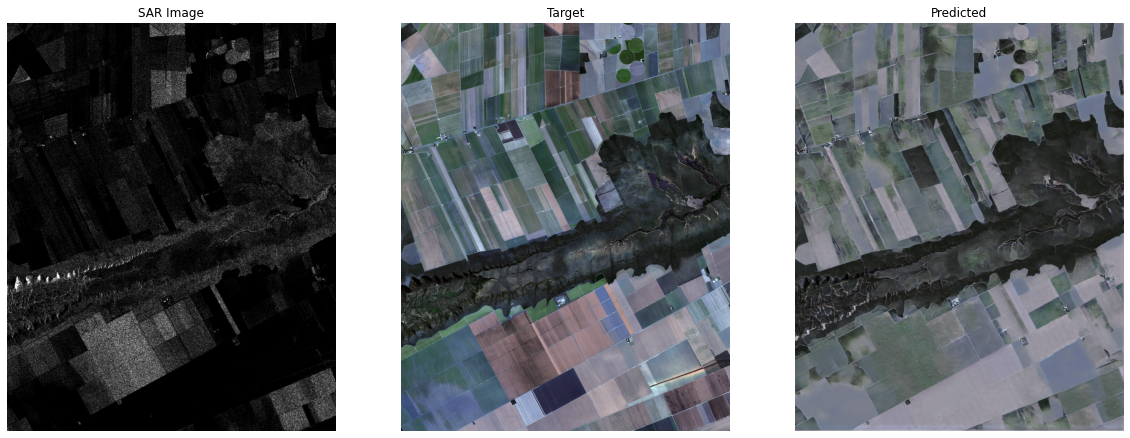

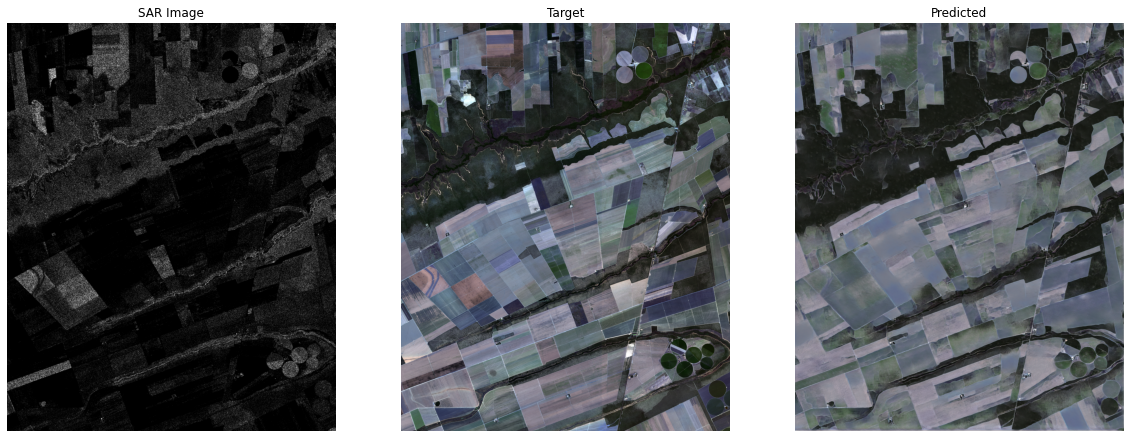

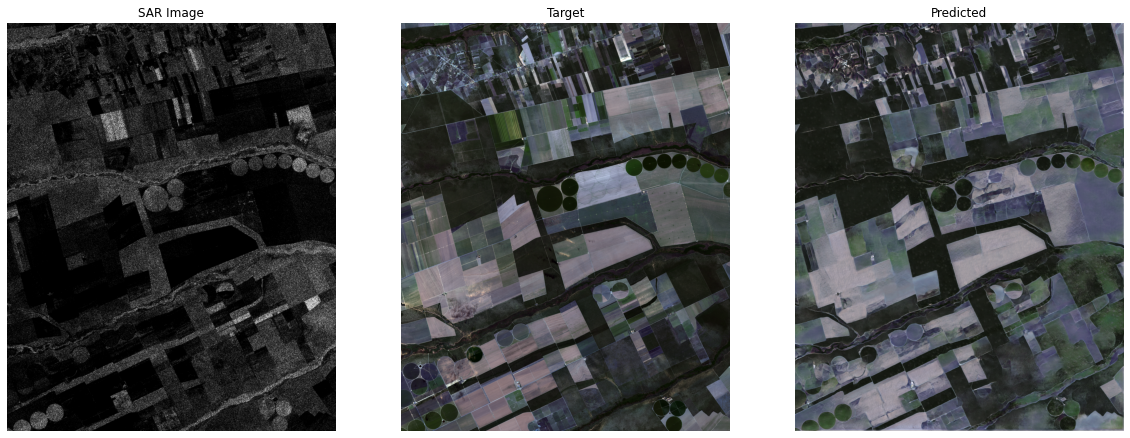

In [ ]:
for tile in tst_tiles:
    S1_tst_tile = S1_img.reshape(-1, c_dim_sar)[tiles_grid_idx[tile]]
    S2_tst_tile = S2_img.reshape(-1, c_dim_opt)[tiles_grid_idx[tile]]
    pred_tst_tile = gen_model.predict(S1_tst_tile)
    plot_images(S1_tst_tile, S2_tst_tile, pred_tst_tile, figsize=(20,10))

## **Exploring the temporal domain**

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/bermudezjose/metadatos/master/multitemporal.png' width="500" height="600"/>
</figure>


In [ ]:
# !git clone https://gitlab.com/josebermudez/42_20180510_s2a_10m.git

In [ ]:
# !unzip 42_20180510_s2a_10m/42_20180510_S2A_10m.zip       